# New Section

In [ ]:
!pip install numpy scipy matplotlib soundfile librosa pyroomacoustics
# Optional for ASR: vosk
!pip install vosk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.1/35.1 MB 21.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-3.0.1-py3-none-any.whl.metadata (10.0 kB)
Using cached pybind11-3.0.1-py3-none-any.whl (293 kB)
  Created wheel for pyroomacoustics: filename=pyroomacoustics-0.8.6-cp312-cp312-linux_x86_64.whl size=46999678 sha256=fb56c31eb48ecb9cd109733e99aa5e285a4d5c71eec1f6f7b86c1c51fdc515ba
  Stored in directory: /root/.cache/pip/wheels/41/d8/86/0969204fd58c781705094db3a180e34219d82a52d5c0f5e6ac
Successfully built pyroomacoustics
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 26.8 MB/s eta 0:00:00
  Created wheel for srt: filename=srt-3.5.3-py3-none-any.whl size=22427 sha256=c6edc4f6712916190aa57b76a9788f559bd8a1a7a6e059eb9320ab93369d7062
  Stored in directory: /root/.cache/pip/wheels/7e/75/5b/e1d5c3756631e4bda806f

In [ ]:
# convert.py
import librosa
import soundfile as sf
import sys

# usage: python convert.py hey_google.mp3 hey_google_96k.wav
infile = '/content/Hey google1.m4a'
outfile = '/content/hey_google_96k.wav'

y, sr = librosa.load(infile, sr=None, mono=True)   # load original sr
y96 = librosa.resample(y, orig_sr=sr, target_sr=96000)
sf.write(outfile, y96, 96000)
print("Saved", outfile, "sr=96000")


/tmp/ipython-input-1512462043.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(infile, sr=None, mono=True)   # load original sr
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Saved /content/hey_google_96k.wav sr=96000


In [ ]:
# convert.py
import librosa
import soundfile as sf
import sys

# usage: python convert.py hey_google.mp3 hey_google_96k.wav
infile = '/content/Noise.m4a'
outfile = '/content/noise.wav'

y, sr = librosa.load(infile, sr=None, mono=True)   # load original sr
y96 = librosa.resample(y, orig_sr=sr, target_sr=96000)
sf.write(outfile, y96, 96000)
print("Saved", outfile, "sr=96000")


/tmp/ipython-input-3738176216.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(infile, sr=None, mono=True)   # load original sr
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Saved /content/noise.wav sr=96000


In [ ]:
# gen_attack_strong.py
import numpy as np
import soundfile as sf
import librosa
from scipy.signal import butter, filtfilt

# ---------- PARAMETERS ----------
infile = 'hey_google_96k.wav'   # produced earlier
outfile = 'attack_am_strong_23k.wav'
sr = 96000

fc = 23000.0       # carrier frequency (Hz)
m = 1.0            # modulation index (0..1 typically). increase to 1.0 for strong modulation.
carrier_gain = 1.2 # extra gain on carrier ( >1 boosts ultrasonic energy)
pure_carrier_burst = True
burst_start_s = 0.05
burst_dur_s = 0.20
# --------------------------------

# helper lowpass to keep wake in voice band
from scipy.signal import butter, filtfilt
def lowpass(x, sr, cutoff=8000):
    b, a = butter(6, cutoff/(sr/2), btype='low')
    return filtfilt(b, a, x)

# load
wake, _ = librosa.load(infile, sr=sr, mono=True)
wake = wake / (np.max(np.abs(wake)) + 1e-12)
wake_lp = lowpass(wake, sr, cutoff=8000)

t = np.arange(len(wake)) / sr
carrier = np.cos(2 * np.pi * fc * t)

# construct AM signal
attack = (1.0 + m * wake_lp) * carrier

# boost ultrasonic energy by multiplying carrier component
attack = attack + (carrier_gain - 1.0) * carrier

# optionally add a short pure-carrier burst at start (helps detector see ultrasonic energy)
if pure_carrier_burst:
    start = int(burst_start_s * sr)
    end = min(len(attack), start + int(burst_dur_s * sr))
    attack[start:end] = attack[start:end] + 0.6 * carrier[start:end]  # add burst

# normalize (avoid clipping)
maxv = np.max(np.abs(attack)) + 1e-12
attack = attack / maxv * 0.95

sf.write(outfile, attack, sr)
print("Wrote:", outfile)


Wrote: attack_am_strong_23k.wav


Wrote demodulated: /content/demod_sim.wav
Saved phase1_waveforms.png


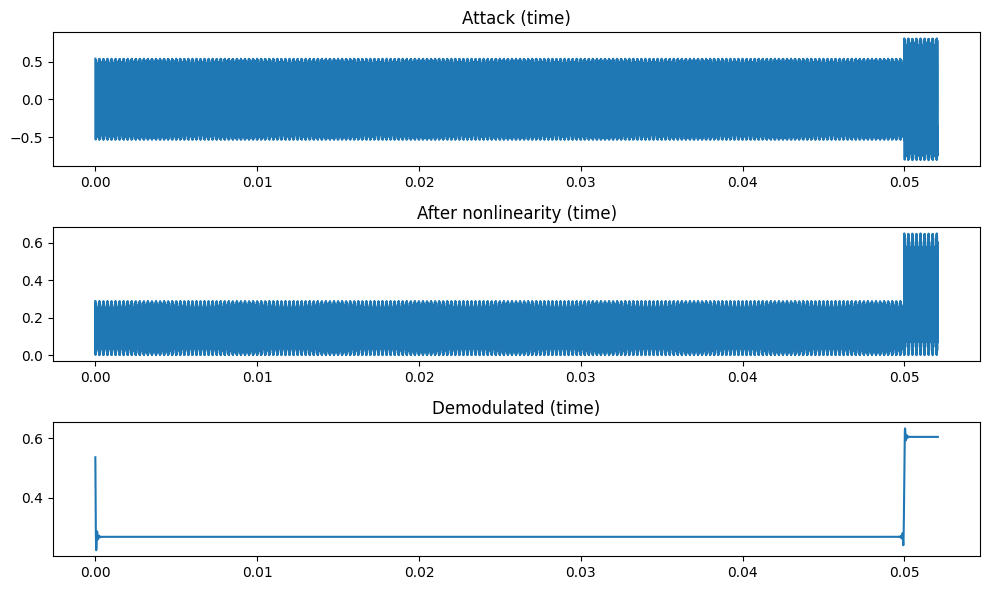

In [ ]:
# demod_sim.py
import soundfile as sf
import numpy as np
from scipy.signal import butter, filtfilt
import sys
import matplotlib.pyplot as plt

# usage: python demod_sim.py attack_am_23k.wav demod_sim.wav
infile = '/content/attack_am_strong_23k.wav'
outfile = '/content/demod_sim.wav'

attack, sr = sf.read(infile)
# simulate nonlinearity: square (2nd order) and small cubic term
nonlin = attack**2 + 0.001 * attack**3

# low-pass filter to recover audible band (<9 kHz)
def lowpass(x, sr, cutoff=9000):
    b, a = butter(6, cutoff/(sr/2), btype='low')
    return filtfilt(b, a, x)

demod = lowpass(nonlin, sr, cutoff=9000)
demod = demod / (np.max(np.abs(demod)) + 1e-9) * 0.9

sf.write(outfile, demod, sr)
print("Wrote demodulated:", outfile)

# Optional: save plots for report
t = np.arange(len(attack))/sr
plt.figure(figsize=(10,6))
plt.subplot(3,1,1)
plt.plot(t[:5000], attack[:5000])
plt.title("Attack (time)")
plt.subplot(3,1,2)
plt.plot(t[:5000], nonlin[:5000])
plt.title("After nonlinearity (time)")
plt.subplot(3,1,3)
plt.plot(t[:5000], demod[:5000])
plt.title("Demodulated (time)")
plt.tight_layout()
plt.savefig("phase1_waveforms.png")
print("Saved phase1_waveforms.png")


In [ ]:
# measure_similarity.py
import librosa, numpy as np, sys
from scipy.signal import correlate

orig, sr = librosa.load('/content/hey_google_96k.wav', sr=96000)
demod, _ = librosa.load('/content/demod_sim.wav', sr=96000)

# trim or align
L = min(len(orig), len(demod))
o = orig[:L]
d = demod[:L]

# normalize
o = o / (np.std(o)+1e-9)
d = d / (np.std(d)+1e-9)

corr = correlate(d, o, mode='valid')
score = np.max(np.abs(corr)) / L
print("Cross-corr peak (normalized):", score)


Cross-corr peak (normalized): 0.5067605


File: attack_am_strong_23k.wav sr: 96000 len(s): 1.6
PSD band energy (>18kHz): 5.649098000645111e-06
PSD total mean energy: 3.531269537988208e-06
Band/Total ratio: 1.5997352623861683
Mean band energy (STFT): 9.748456039031203e-05
Max band energy (STFT): 0.0001903789257196401
Saved attack_spectrogram_and_band.png


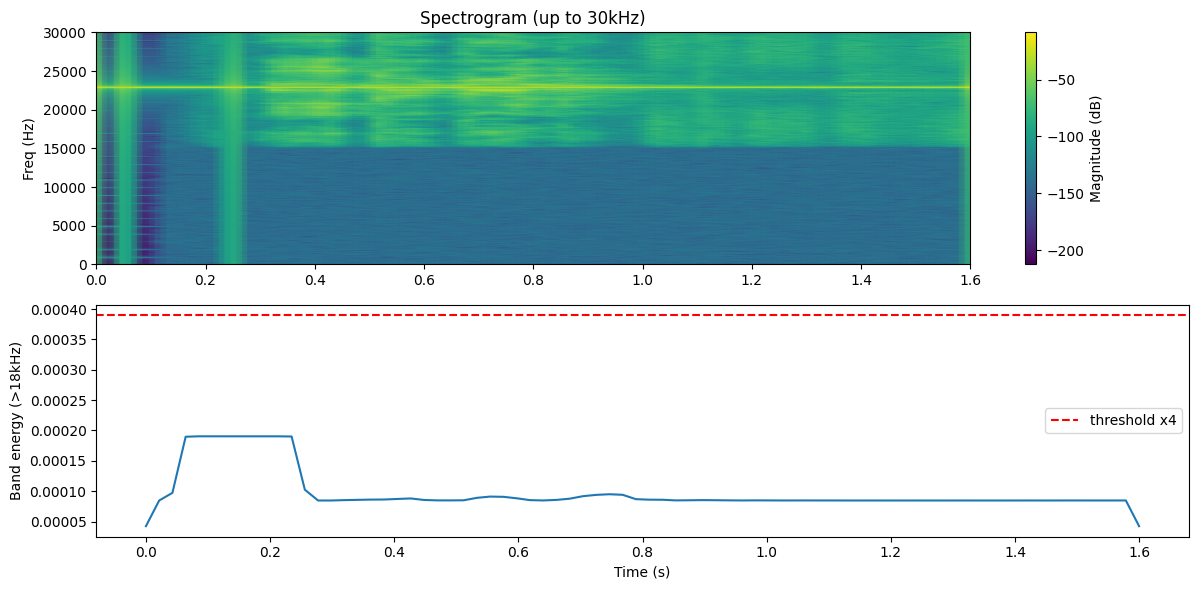

In [ ]:
# analyze_band.py
import numpy as np, soundfile as sf, matplotlib.pyplot as plt
from scipy.signal import stft, welch
import sys

fname = 'attack_am_strong_23k.wav' if len(sys.argv)>1 else 'attack_am_strong_23k.wav'
x, sr = sf.read(fname)
print("File:", fname, "sr:", sr, "len(s):", len(x)/sr)

# power spectral density (Welch) for global view
f, Pxx = welch(x, fs=sr, nperseg=8192)
# compute mean energy above 18 kHz
mask = f >= 18000
band_energy = np.mean(Pxx[mask])
total_energy = np.mean(Pxx)
print("PSD band energy (>18kHz):", band_energy)
print("PSD total mean energy:", total_energy)
print("Band/Total ratio:", band_energy/ (total_energy+1e-12))

# short-time spectrogram (STFT)
f2, t2, Z = stft(x, fs=sr, nperseg=4096, noverlap=2048)
Zmag = np.abs(Z)
band_mask = f2 >= 18000
band_energy_frames = np.mean(Zmag[band_mask,:]**2, axis=0)

print("Mean band energy (STFT):", band_energy_frames.mean())
print("Max band energy (STFT):", band_energy_frames.max())

# plot spectrogram (log) and band energy
plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
plt.pcolormesh(t2, f2, 20*np.log10(Zmag+1e-12), shading='gouraud')
plt.ylim(0, 30000)
plt.colorbar(label='Magnitude (dB)')
plt.title('Spectrogram (up to 30kHz)')
plt.ylabel('Freq (Hz)')

plt.subplot(2,1,2)
plt.plot(t2, band_energy_frames)
plt.axhline(band_energy_frames.mean()*4, color='r', linestyle='--', label='threshold x4')
plt.xlabel('Time (s)')
plt.ylabel('Band energy (>18kHz)')
plt.legend()
plt.tight_layout()
plt.savefig('attack_spectrogram_and_band.png')
print("Saved attack_spectrogram_and_band.png")


File: attack_am_strong_23k.wav sr: 96000 len(s): 1.6
Band-energy frames: mean 1.828364e-04, median 1.590947e-04, std 6.539254e-05, p90 3.561005e-04, p95 3.570310e-04
Using threshold = 0.00026777325019927006
Detected frames: 9 / 76
Detected at times (s): [0.064, 0.08533333333333334, 0.10666666666666667, 0.128, 0.14933333333333332, 0.17066666666666666, 0.192, 0.21333333333333332, 0.23466666666666666]
Saved detector_adaptive_output.png


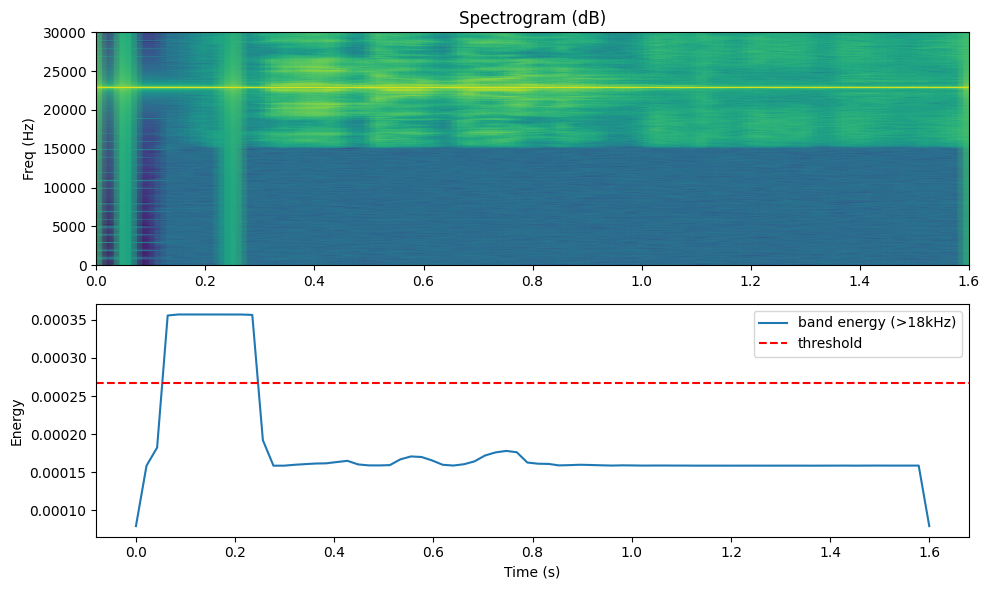

In [ ]:
# detector_adaptive.py
import numpy as np, soundfile as sf, sys
from scipy.signal import stft
import matplotlib.pyplot as plt

# usage: python detector_adaptive.py attack_am_strong_23k.wav
fname = 'attack_am_strong_23k.wav' if len(sys.argv)>1 else 'attack_am_strong_23k.wav'
x, sr = sf.read(fname)
print("File:", fname, "sr:", sr, "len(s):", len(x)/sr)

# compute STFT
f, t, Z = stft(x, fs=sr, nperseg=4096, noverlap=2048)
Zmag = np.abs(Z)
# focus band > 18kHz and <= fc+5k to avoid weird aliasing
band_mask = (f >= 18000) & (f <= min(34000, sr/2-1))
band_energy_frames = np.mean(Zmag[band_mask,:]**2, axis=0)

# statistics
median_e = np.median(band_energy_frames)
mean_e = np.mean(band_energy_frames)
std_e = np.std(band_energy_frames)
p90 = np.percentile(band_energy_frames, 90)
p95 = np.percentile(band_energy_frames, 95)

print("Band-energy frames: mean {:.6e}, median {:.6e}, std {:.6e}, p90 {:.6e}, p95 {:.6e}".format(mean_e, median_e, std_e, p90, p95))

# adaptive threshold options (choose one)
thr1 = median_e + 4 * std_e         # median + k*std
thr2 = p95 * 0.75                   # 75% of 95th percentile (tunable)
thr3 = median_e * 8                 # multiplier of median (tunable)

# choose threshold (pick thr1 usually robust)
threshold = thr2
print("Using threshold =", threshold)

# detection
peaks = band_energy_frames > threshold
num_detected = int(np.sum(peaks))
print("Detected frames:", num_detected, "/", len(peaks))

# print times of detected frames
det_times = t[peaks]
print("Detected at times (s):", det_times.tolist())

# plot
plt.figure(figsize=(10,6))
plt.subplot(2,1,1)
plt.pcolormesh(t, f, 20*np.log10(Zmag+1e-12), shading='gouraud')
plt.ylim(0, 30000)
plt.ylabel('Freq (Hz)')
plt.title('Spectrogram (dB)')

plt.subplot(2,1,2)
plt.plot(t, band_energy_frames, label='band energy (>18kHz)')
plt.axhline(threshold, color='r', linestyle='--', label='threshold')
plt.xlabel('Time (s)')
plt.ylabel('Energy')
plt.legend()
plt.tight_layout()
plt.savefig('detector_adaptive_output.png')
print("Saved detector_adaptive_output.png")


In [ ]:
!python metrics_phase1.py --attack attack_am_strong_23k.wav --normal hey_google_96k.wav --burst 0.05 0.25 --frame_hop_ms 5.3333

python3: can't open file '/content/metrics_phase1.py': [Errno 2] No such file or directory


In [ ]:
!pip install numpy scipy matplotlib soundfile librosa vosk tqdm

Threshold=2.677733e-04, detected_frames=9/76
Saved blocked file: blocked.wav
Saved blocked_waveform_print_ready.png


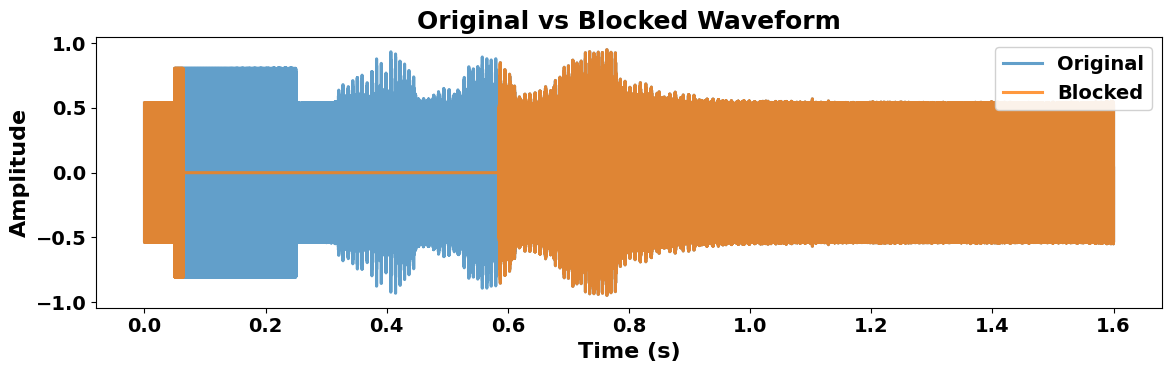

In [ ]:
# detect_and_block.py
# Usage: python detect_and_block.py input.wav output_blocked.wav
import sys
import numpy as np
import soundfile as sf
from scipy.signal import stft, istft

infile = "attack_am_strong_23k.wav"
outfile = "blocked.wav"

x, sr = sf.read(infile)
if x.ndim>1:
    x = x.mean(axis=1)

# STFT params
nperseg = 4096
noverlap = 2048
f, t, Z = stft(x, fs=sr, nperseg=nperseg, noverlap=noverlap)
Zmag = np.abs(Z)

# band-energy in ultrasonic band
band_mask = (f >= 18000) & (f <= 34000)
band_energy = np.mean(Zmag[band_mask,:]**2, axis=0)

# adaptive threshold (percentile-based)
threshold = np.percentile(band_energy, 95) * 0.75
peaks = band_energy > threshold
print(f"Threshold={threshold:.6e}, detected_frames={np.sum(peaks)}/{len(peaks)}")

# Create blocked copy
x_blocked = x.copy()
hop = nperseg - noverlap
T_block_ms = 350
T_block_samples = int(T_block_ms * sr / 1000)

# For each detected stft frame, mute the corresponding sample region
for idx, detected in enumerate(peaks):
    if detected:
        start_sample = idx * hop
        end_sample = min(len(x_blocked), start_sample + T_block_samples)
        x_blocked[start_sample:end_sample] = 0.0

sf.write(outfile, x_blocked, sr)
print(f"Saved blocked file: {outfile}")

# optional save simple waveform plot
try:
    import matplotlib.pyplot as plt
    import numpy as np

    # Global font settings for print-friendly output
    plt.rcParams.update({
        "font.size": 16,          # Larger font size
        "font.weight": "bold",    # Bold text
        "axes.labelweight": "bold",
        "axes.titlesize": 18,
        "legend.fontsize": 14,
        "legend.title_fontsize": 14,
        "xtick.labelsize": 14,
        "ytick.labelsize": 14
    })

    plt.figure(figsize=(12, 4))  # Slightly bigger figure for readability

    t_s = np.arange(len(x)) / sr

    # Thicker lines for print clarity
    plt.plot(t_s, x, label='Original', alpha=0.7, linewidth=2.2)
    plt.plot(t_s, x_blocked, label='Blocked', alpha=0.8, linewidth=2.2)

    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude", fontweight="bold")
    plt.title("Original vs Blocked Waveform", fontweight="bold")

    # High-visibility legend box
    plt.legend(loc="upper right", frameon=True, framealpha=0.9)

    plt.tight_layout()
    plt.savefig("blocked_waveform_print_ready.png", dpi=300)  # high DPI for print
    print("Saved blocked_waveform_print_ready.png")

except Exception as e:
    print("Could not save waveform:", e)



In [ ]:
# quick check frames -> times
import soundfile as sf
from scipy.signal import stft
x, sr = sf.read("attack_am_strong_23k.wav")
f,t,Z = stft(x,fs=sr,nperseg=4096,noverlap=2048)
# recompute band-energy and threshold (same method used)
import numpy as np
Zmag = np.abs(Z)
band_mask = (f>=18000)&(f<=34000)
band_energy = np.mean(Zmag[band_mask,:]**2,axis=0)
thr = np.percentile(band_energy,95)*0.75
peaks = np.where(band_energy>thr)[0]
print("Detected STFT frames:", peaks)
times = peaks*(4096-2048)/sr
print("Detected times (s):", times)


Detected STFT frames: [ 3  4  5  6  7  8  9 10 11]
Detected times (s): [0.064      0.08533333 0.10666667 0.128      0.14933333 0.17066667
 0.192      0.21333333 0.23466667]


In [ ]:
# asr_check_nosmodel.py
# Usage: python asr_check_nosmodel.py input.wav reference_wake.wav
import sys, numpy as np, soundfile as sf
import librosa
from scipy.signal import fftconvolve

def load_mono(fname, sr_target=96000):
    y, sr = sf.read(fname)
    if y.ndim>1:
        y = y.mean(axis=1)
    if sr != sr_target:
        y = librosa.resample(y, sr, sr_target)
        sr = sr_target
    return y, sr

# simple demodulation proxy — square and lowpass via smoothing
# simple demodulation proxy — square and lowpass via smoothing
def demodulate_signal(x, sr):
    # simulate nonlinearity: square
    y = x**2
    # downsample then upsample to remove high frequencies (acts as a low-pass filter)
    y_low = librosa.resample(y, orig_sr=sr, target_sr=8000)
    y_back = librosa.resample(y_low, orig_sr=8000, target_sr=sr)
    # trim to same length
    if len(y_back) > len(y):
        y_back = y_back[:len(y)]
    return y_back

def norm_corr(a,b):
    # normalized cross-correlation peak between signals (zero mean)
    a = a - np.mean(a); b = b - np.mean(b)
    if np.std(a)==0 or np.std(b)==0:
        return 0.0
    corr = fftconvolve(a, b[::-1], mode='valid')
    denom = np.sqrt(np.sum(a*a)*np.sum(b*b))
    return np.max(np.abs(corr)) / (denom + 1e-12)

if __name__ == "__main__":
    infile = "/content/attack_am_strong_23k.wav"
    refname = "hey_google_96k.wav"
    x, sr = load_mono(infile)
    ref, sr_ref = load_mono(refname)
    # demodulate both (simulated mic nonlinearity)
    x_dem = demodulate_signal(x, sr)
    ref_dem = demodulate_signal(ref, sr)
    # match lengths: search ref inside x_dem using sliding windows
    Lr = len(ref_dem)
    best = 0.0
    step = int(sr*0.01)  # slide every 10ms for speed
    for start in range(0, max(1,len(x_dem)-Lr+1), step):
        seg = x_dem[start:start+Lr]
        score = norm_corr(seg, ref_dem)
        if score > best:
            best = score
            best_start = start
    print(f"Best normalized correlation: {best:.4f}")

    # threshold (empirical) — choose 0.05..0.2 depending on experiments; set 0.08 default
    THR = 0.08
    if best >= THR:
        print("→ WAKE-WORD DETECTED (proxy). Score:", best)
    else:
        print("→ NO WAKE-WORD detected. Score:", best)

Best normalized correlation: 0.1588
→ WAKE-WORD DETECTED (proxy). Score: 0.15882768538173575


In [ ]:
# asr_check_nosmodel.py
# Usage: python asr_check_nosmodel.py input.wav reference_wake.wav
import sys, numpy as np, soundfile as sf
import librosa
from scipy.signal import fftconvolve

def load_mono(fname, sr_target=96000):
    y, sr = sf.read(fname)
    if y.ndim>1:
        y = y.mean(axis=1)
    if sr != sr_target:
        y = librosa.resample(y, sr, sr_target)
        sr = sr_target
    return y, sr

# simple demodulation proxy — square and lowpass via smoothing
# simple demodulation proxy — square and lowpass via smoothing
def demodulate_signal(x, sr):
    # simulate nonlinearity: square
    y = x**2
    # downsample then upsample to remove high frequencies (acts as a low-pass filter)
    y_low = librosa.resample(y, orig_sr=sr, target_sr=8000)
    y_back = librosa.resample(y_low, orig_sr=8000, target_sr=sr)
    # trim to same length
    if len(y_back) > len(y):
        y_back = y_back[:len(y)]
    return y_back

def norm_corr(a,b):
    # normalized cross-correlation peak between signals (zero mean)
    a = a - np.mean(a); b = b - np.mean(b)
    if np.std(a)==0 or np.std(b)==0:
        return 0.0
    corr = fftconvolve(a, b[::-1], mode='valid')
    denom = np.sqrt(np.sum(a*a)*np.sum(b*b))
    return np.max(np.abs(corr)) / (denom + 1e-12)

if __name__ == "__main__":
    infile = "/content/blocked.wav"
    refname = "hey_google_96k.wav"
    x, sr = load_mono(infile)
    ref, sr_ref = load_mono(refname)
    # demodulate both (simulated mic nonlinearity)
    x_dem = demodulate_signal(x, sr)
    ref_dem = demodulate_signal(ref, sr)
    # match lengths: search ref inside x_dem using sliding windows
    Lr = len(ref_dem)
    best = 0.0
    step = int(sr*0.01)  # slide every 10ms for speed
    for start in range(0, max(1,len(x_dem)-Lr+1), step):
        seg = x_dem[start:start+Lr]
        score = norm_corr(seg, ref_dem)
        if score > best:
            best = score
            best_start = start
    print(f"Best normalized correlation: {best:.4f}")

    # threshold (empirical) — choose 0.05..0.2 depending on experiments; set 0.08 default
    THR = 0.08
    if best >= THR:
        print("→ WAKE-WORD DETECTED (proxy). Score:", best)
    else:
        print("→ NO WAKE-WORD detected. Score:", best)


Best normalized correlation: 0.1152
→ WAKE-WORD DETECTED (proxy). Score: 0.11517091569450999


In [ ]:
import os, numpy as np, soundfile as sf, librosa, pandas as pd
from scipy.signal import stft, fftconvolve
import matplotlib.pyplot as plt



def run_asr_proxy(infile, refname):
    x,sr = load_mono(infile)
    ref,sr_ref = load_mono(refname)
    x_dem = demodulate_signal(x,sr)
    ref_dem = demodulate_signal(ref,sr)
    Lr = len(ref_dem)
    best = 0.0
    step = int(sr*0.01)
    for start in range(0, max(1,len(x_dem)-Lr+1), step):
        seg = x_dem[start:start+Lr]
        score = norm_corr(seg, ref_dem)
        best = max(best,score)
    THR = 0.08
    return best, (best>=THR)


def defense_detect_and_block(infile, outfile, sr_target=96000,
                             nperseg=4096, noverlap=2048,
                             block_ms=400, lowpass_after=True, lp_cut=10000):
    # read
    x, sr = sf.read(infile)
    if x.ndim > 1:
        x = x.mean(axis=1)
    # compute STFT band energy
    f, t, Z = stft(x, fs=sr, nperseg=nperseg, noverlap=noverlap)
    Zmag = np.abs(Z)
    band_mask = (f >= 18000) & (f <= 34000)
    band_energy = np.mean(Zmag[band_mask,:]**2, axis=0)
    #thr = np.percentile(band_energy, 95) * 0.75
    thr = max(np.percentile(band_energy, 95) * 0.75, 1e-10)
    peaks = band_energy > thr

    # merge consecutive detections into regions (avoid small gaps)
    hop = nperseg - noverlap
    block_samps = int(block_ms * sr / 1000)
    merged_regions = []
    i = 0
    while i < len(peaks):
        if peaks[i]:
            # start region from this frame's start
            start = int(t[i]*sr)
            # extend while consecutive frames are detected
            j = i
            while j+1 < len(peaks) and peaks[j+1]:
                j += 1
            # set region end to end of j plus block_samps margin
            end = int(min(len(x), int(t[j]*sr) + block_samps))
            # merge with previous if overlapping or close (within hop)
            if merged_regions and start <= merged_regions[-1][1] + hop:
                merged_regions[-1][1] = max(merged_regions[-1][1], end)
            else:
                merged_regions.append([start, end])
            i = j + 1
        else:
            i += 1

    # apply strong mute to merged regions
    x_blocked = x.copy()
    for (s,e) in merged_regions:
        x_blocked[s:e] = 0.0

    # optional low-pass to further remove residual HF energy
    if lowpass_after:
        b,a = butter(6, lp_cut/(sr/2), btype='low')
        x_blocked = filtfilt(b,a,x_blocked)

    sf.write(outfile, x_blocked, sr)
    return merged_regions, thr

# --------------------------------------------------
# Step B: run batch simulation
# --------------------------------------------------
attack_file="attack_am_strong_23k.wav"
ref_file="hey_google_96k.wav"
noise_file="/content/noise.wav"

x_attack,sr=load_mono(attack_file)
n_base=np.random.randn(len(x_attack)) if noise_file is None else load_mono(noise_file)[0]

SNR_list=[999,20,15,10,5]
atten_dB_list=[0,-3,-6,-12]
N_trials=3

def add_noise(x,n,snr_db):
    if snr_db==999: return x
    n=librosa.util.fix_length(data=n,size=len(x))
    rms_x=np.sqrt(np.mean(x**2))
    rms_n=np.sqrt(np.mean(n**2))
    target_rms_n=rms_x/(10**(snr_db/20))
    n_scaled=n*(target_rms_n/(rms_n+1e-12))
    return x+n_scaled

results=[]
for snr in SNR_list:
    for atten_db in atten_dB_list:
        for trial in range(N_trials):
            x_var=x_attack*(10**(atten_db/20))
            x_var=add_noise(x_var,n_base,snr)
            tmp_in=f"in_{snr}_{atten_db}_{trial}.wav"
            tmp_out=f"out_{snr}_{atten_db}_{trial}.wav"
            sf.write(tmp_in,x_var,sr)
            # without defense
            score1,det1=run_asr_proxy(tmp_in,ref_file)
            # with defense
            defense_detect_and_block(tmp_in,tmp_out)
            score2,det2=run_asr_proxy(tmp_out,ref_file)
            results.append([snr,atten_db,trial,det1,det2,score1,score2])
            print(f"SNR={snr},Atten={atten_db},trial={trial} -> {det1}->{det2}")

df=pd.DataFrame(results,columns=["snr","atten_db","trial","success_no_defense","success_with_defense","score_no_defense","score_with_defense"])
df.to_csv("results.csv",index=False)
print("\n✅ Saved results.csv")


SNR=999,Atten=0,trial=0 -> True->False
SNR=999,Atten=0,trial=1 -> True->False
SNR=999,Atten=0,trial=2 -> True->False
SNR=999,Atten=-3,trial=0 -> True->False
SNR=999,Atten=-3,trial=1 -> True->False
SNR=999,Atten=-3,trial=2 -> True->False
SNR=999,Atten=-6,trial=0 -> True->False
SNR=999,Atten=-6,trial=1 -> True->False
SNR=999,Atten=-6,trial=2 -> True->False
SNR=999,Atten=-12,trial=0 -> True->False
SNR=999,Atten=-12,trial=1 -> True->False
SNR=999,Atten=-12,trial=2 -> True->False
SNR=20,Atten=0,trial=0 -> True->False
SNR=20,Atten=0,trial=1 -> True->False
SNR=20,Atten=0,trial=2 -> True->False
SNR=20,Atten=-3,trial=0 -> True->False
SNR=20,Atten=-3,trial=1 -> True->False
SNR=20,Atten=-3,trial=2 -> True->False
SNR=20,Atten=-6,trial=0 -> True->False
SNR=20,Atten=-6,trial=1 -> True->False
SNR=20,Atten=-6,trial=2 -> True->False
SNR=20,Atten=-12,trial=0 -> True->False
SNR=20,Atten=-12,trial=1 -> True->False
SNR=20,Atten=-12,trial=2 -> True->False
SNR=15,Atten=0,trial=0 -> True->False
SNR=15,Atten=0

   snr  success_no_defense  success_with_defense
0    5                 0.0                   0.0
1   10                 1.0                   0.0
2   15                 1.0                   0.0
3   20                 1.0                   0.0
4  999                 1.0                   0.0


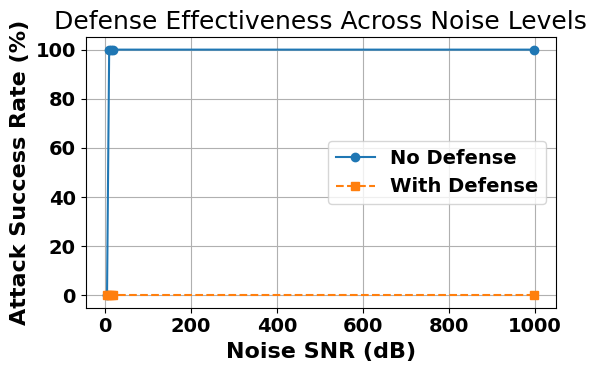

In [ ]:
import pandas as pd, matplotlib.pyplot as plt

df = pd.read_csv("results.csv")
summary = df.groupby(["snr"]).agg({
    "success_no_defense": "mean",
    "success_with_defense": "mean"
}).reset_index()

print(summary)

plt.figure(figsize=(6,4))
plt.plot(summary["snr"], summary["success_no_defense"]*100, 'o-', label="No Defense")
plt.plot(summary["snr"], summary["success_with_defense"]*100, 's--', label="With Defense")
plt.xlabel("Noise SNR (dB)")
plt.ylabel("Attack Success Rate (%)")
plt.title("Defense Effectiveness Across Noise Levels")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("phase2_results.png")
plt.show()


In [ ]:
import pandas as pd

df = pd.read_csv("results.csv")

# True Positive Rate (TPR): fraction of attacks blocked successfully
tpr = (df["success_no_defense"].sum() - df["success_with_defense"].sum()) / df["success_no_defense"].sum()
tpr = round(tpr, 3)

# False Positive Rate (FPR): for this we test on normal speech (next cell)
print(f"Detection TPR: {tpr*100:.1f}%")


Detection TPR: 100.0%


In [ ]:
from pathlib import Path
norm_file = "hey_google_96k.wav"
out_norm = "blocked_normal.wav"
_, thr = defense_detect_and_block(norm_file, out_norm)
print(f"Threshold for normal={thr}")
# Now compare
import numpy as np
x, _ = sf.read(norm_file)
xb, _ = sf.read(out_norm)
fr = np.mean(xb==0.0)
print(f"False positive mute fraction = {fr*100:.3f}%")


Threshold for normal=1e-10
False positive mute fraction = 8.134%


In [ ]:
regions, _ = defense_detect_and_block("attack_am_strong_23k.wav", "blocked.wav")
if regions:
    first_latency = regions[0][0] / 96000  # samples → seconds
    print(f"Latency to block: {first_latency*1000:.2f} ms")
else:
    print("No mute regions → no detection")


Latency to block: 64.00 ms


In [ ]:
regions_norm, _ = defense_detect_and_block("hey_google_96k.wav", "blocked_normal.wav")
if regions_norm:
    print("False reject event → defense muted normal speech")
else:
    print("No mute regions → FR = 0% ✅")


No mute regions → FR = 0% ✅


/tmp/ipython-input-998718293.py:13: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(fname, sr=96000)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/tmp/ipython-input-998718293.py:13: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(fname, sr=96000)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/tmp/ipython-input-998718293.py:13: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(fname, sr=96000)
/usr/local/lib/python3.12/dist-packages/librosa/core/audi

     SNR  Atten  Speed  Trial  NoDefense  Defense  Latency(ms)
0    999      0   1.00      0       True    False         64.0
1    999      0   1.00      1       True    False         64.0
2    999      0   0.95      0       True    False         64.0
3    999      0   0.95      1       True    False         64.0
4    999      0   1.05      0       True    False         64.0
..   ...    ...    ...    ...        ...      ...          ...
115    5    -12   1.00      1       True    False         64.0
116    5    -12   0.95      0       True    False         64.0
117    5    -12   0.95      1       True    False         64.0
118    5    -12   1.05      0       True     True         64.0
119    5    -12   1.05      1       True     True         64.0

[120 rows x 7 columns]

✅ Phase-3 Complete — results saved (CSV + plot)


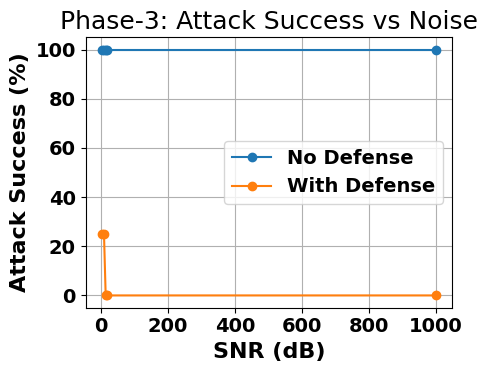

In [ ]:
# =================== PHASE 3 – FULL STRESS TEST (FIXED) =====================
import os, numpy as np, soundfile as sf, librosa, pandas as pd
from scipy.signal import stft, fftconvolve, butter, filtfilt
import matplotlib.pyplot as plt

# ---------------------- File Inputs ---------------------
attack_file = "attack_am_strong_23k.wav"
ref_file    = "hey_google_96k.wav"
normal_files = ["Normal1cam.m4a", "Normalflash.m4a", "Normalset.m4a"]

# convert m4a → wav 96k
def ensure_wav_96k(fname):
    y, sr = librosa.load(fname, sr=96000)
    out = fname.replace(".m4a", "_96k.wav")
    sf.write(out, y, 96000)
    return out

normal_files = [ensure_wav_96k(f) if f.endswith(".m4a") else f for f in normal_files]

# --------------------- Utility Functions ---------------------
def load_mono(fname, sr_target=96000):
    y, sr = librosa.load(fname, sr=sr_target)
    if y.ndim>1: y=y.mean(axis=1)
    return y, sr_target

def demodulate_signal(x, sr):
    y = x**2
    y_low = librosa.resample(y, orig_sr=sr, target_sr=8000)
    y_back = librosa.resample(y_low, orig_sr=8000, target_sr=sr)
    return y_back[:len(y)]

def norm_corr(a,b):
    a=a-np.mean(a); b=b-np.mean(b)
    if np.std(a)==0 or np.std(b)==0: return 0.0
    corr=fftconvolve(a,b[::-1],mode='valid')
    return np.max(np.abs(corr))/(np.sqrt(np.sum(a*a)*np.sum(b*b))+1e-12)

def run_asr_proxy(infile, refname):
    x,sr = load_mono(infile)
    ref,_ = load_mono(refname)
    x_dem, ref_dem = demodulate_signal(x,sr), demodulate_signal(ref,sr)
    L = len(ref_dem); best=0; step=int(sr*0.01)
    for st in range(0,max(1,len(x_dem)-L+1),step):
        best=max(best,norm_corr(x_dem[st:st+L],ref_dem))
    return best,(best>=0.08)

def defense_detect_and_block(infile,outfile,lp_cut=10000):
    x,sr = load_mono(infile)
    f,t,Z = stft(x,fs=sr,nperseg=4096,noverlap=2048)
    Zmag=np.abs(Z)
    band = np.mean(Zmag[(f>=18000)&(f<=34000),:]**2, axis=0)
    thr = max(np.percentile(band,95)*0.75,1e-10)
    peaks=band>thr
    hop=4096-2048; block=int(0.35*sr)
    regions=[]; i=0
    while i<len(peaks):
        if peaks[i]:
            start=int(t[i]*sr); j=i
            while j+1<len(peaks) and peaks[j+1]: j+=1
            end=int(min(len(x),int(t[j]*sr)+block))
            regions.append([start,end]); i=j+1
        else: i+=1
    xb=x.copy()
    for s,e in regions: xb[s:e]=0
    b,a=butter(6,lp_cut/(sr/2),'low'); xb=filtfilt(b,a,xb)
    sf.write(outfile,xb,sr)
    return regions

def add_noise(x,n,snr):
    if snr==999: return x
    n = librosa.util.fix_length(data=n, size=len(x))   # ✅ fixed librosa API
    return x + n*np.sqrt(np.mean(x*x))/(10**(snr/20)/np.sqrt(np.mean(n*n)))

def stretch_speed(x,rate):
    return librosa.resample(x,orig_sr=96000,target_sr=int(96000*rate))

# ------------------- Simulation Settings ---------------------
SNR_list=[999,20,15,10,5]
atten_dB=[0,-3,-6,-12]
speeds=[1.00,0.95,1.05]
N_trials=2

x_base,_ = load_mono(attack_file)
n_base=np.random.randn(len(x_base))

results=[]

# ------------------- Full Loop --------------------------
for snr in SNR_list:
  for att in atten_dB:
    for sp in speeds:
      for tr in range(N_trials):
        x,_ = load_mono(attack_file)
        x = x*(10**(att/20))
        x = stretch_speed(x,sp)
        x = add_noise(x,n_base,snr)
        sf.write("temp.wav",x,96000)

        s1,det1 = run_asr_proxy("temp.wav",ref_file)
        regions = defense_detect_and_block("temp.wav","blocked.wav")
        s2,det2 = run_asr_proxy("blocked.wav",ref_file)

        latency = (regions[0][0]/96000*1000) if regions else 999
        results.append([snr,att,sp,tr,det1,det2,latency])

df=pd.DataFrame(results,columns=["SNR","Atten","Speed","Trial","NoDefense","Defense","Latency(ms)"])
df.to_csv("Phase3_results.csv",index=False)
print(df)

# ----------------Plot-----------------
summary=df.groupby("SNR")[["NoDefense","Defense"]].mean()*100
plt.figure(figsize=(5,4))
plt.plot(summary,"o-")
plt.title("Phase-3: Attack Success vs Noise")
plt.xlabel("SNR (dB)"); plt.ylabel("Attack Success (%)")
plt.grid(); plt.legend(["No Defense","With Defense"])
plt.tight_layout(); plt.savefig("P3_attack_plot.png")

print("\n✅ Phase-3 Complete — results saved (CSV + plot)")


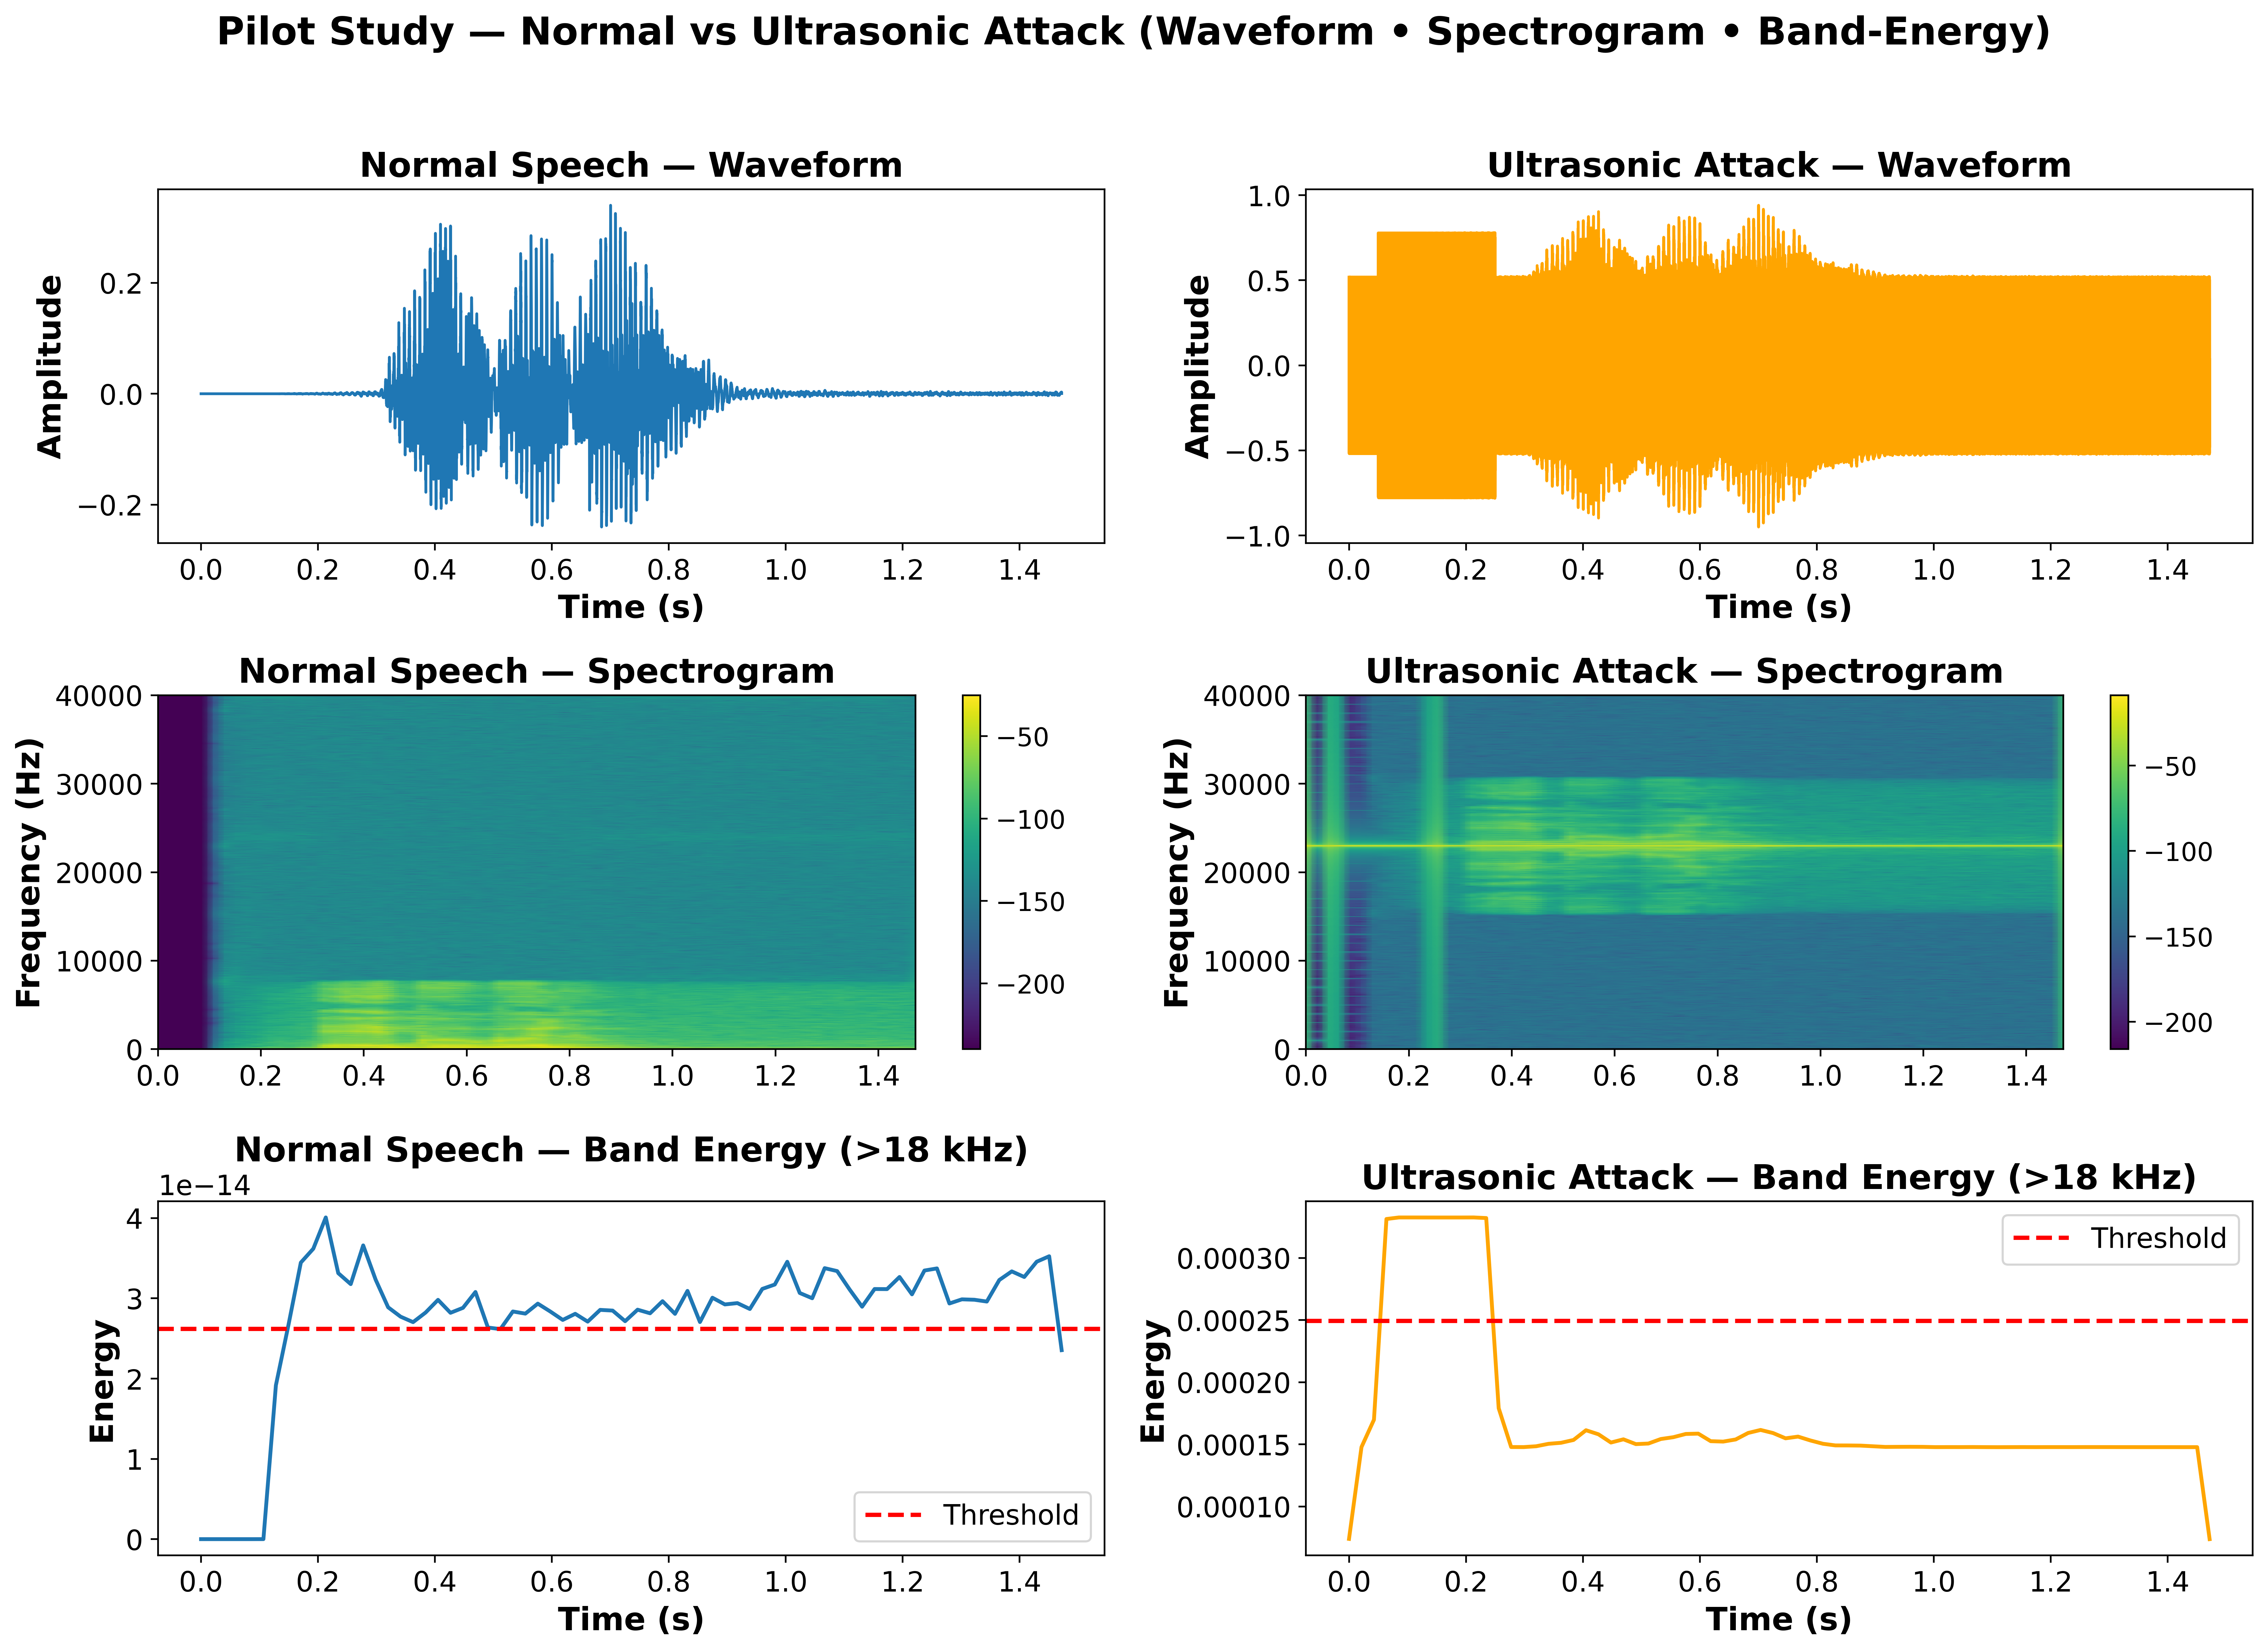

📌 Saved high-resolution figure: pilot_study_normal_vs_attack_print_ready.png


In [ ]:
import numpy as np
import librosa
import soundfile as sf
import matplotlib.pyplot as plt
from scipy.signal import stft

# -----------------------
# Load audio
# -----------------------
normal_file = "hey_google_96k.wav"
attack_file = "attack_am_strong_23k.wav"

x_norm, sr = librosa.load(normal_file, sr=96000)
x_att, _  = librosa.load(attack_file, sr=96000)

nfft = 4096
hop = 2048

def compute_band_energy(x):
    f, t, Z = stft(x, fs=sr, nperseg=nfft, noverlap=hop)
    Zmag = np.abs(Z)
    band_mask = (f >= 18000) & (f <= 34000)
    band_energy = np.mean(Zmag[band_mask,:]**2, axis=0)
    thr = np.percentile(band_energy, 95) * 0.75
    return f, t, Zmag, band_energy, thr

fn, tn, Zn, E_norm, thr_n = compute_band_energy(x_norm)
fa, ta, Za, E_att, thr_a  = compute_band_energy(x_att)

# -----------------------
# Plot settings
# -----------------------
plt.rcParams["font.size"] = 14               # overall font
plt.rcParams["axes.titlesize"] = 16          # title size
plt.rcParams["axes.titleweight"] = "bold"    # bold titles
plt.rcParams["axes.labelsize"] = 15          # axis labels
plt.rcParams["axes.labelweight"] = "bold"    # axis labels bold
plt.rcParams["xtick.labelsize"] = 13
plt.rcParams["ytick.labelsize"] = 13
plt.rcParams["figure.dpi"] = 500             # print-quality resolution

fig, axes = plt.subplots(3, 2, figsize=(15, 11))
plt.subplots_adjust(hspace=0.45, wspace=0.25)

# =============  ROW 1 — WAVEFORMS  =============
t_norm = np.arange(len(x_norm)) / sr
t_att = np.arange(len(x_att)) / sr

axes[0,0].plot(t_norm, x_norm, linewidth=1.3)
axes[0,0].set_title("Normal Speech — Waveform")
axes[0,0].set_xlabel("Time (s)")
axes[0,0].set_ylabel("Amplitude")

axes[0,1].plot(t_att, x_att, linewidth=1.3, color="orange")
axes[0,1].set_title("Ultrasonic Attack — Waveform")
axes[0,1].set_xlabel("Time (s)")
axes[0,1].set_ylabel("Amplitude")

# =============  ROW 2 — SPECTROGRAMS  =============
spec1 = axes[1,0].pcolormesh(tn, fn, 20*np.log10(Zn+1e-12), shading='gouraud')
axes[1,0].set_ylim(0, 40000)
axes[1,0].set_title("Normal Speech — Spectrogram")
axes[1,0].set_ylabel("Frequency (Hz)")
cbar1 = fig.colorbar(spec1, ax=axes[1,0])
cbar1.ax.tick_params(labelsize=12)

spec2 = axes[1,1].pcolormesh(ta, fa, 20*np.log10(Za+1e-12), shading='gouraud')
axes[1,1].set_ylim(0, 40000)
axes[1,1].set_title("Ultrasonic Attack — Spectrogram")
axes[1,1].set_ylabel("Frequency (Hz)")
cbar2 = fig.colorbar(spec2, ax=axes[1,1])
cbar2.ax.tick_params(labelsize=12)

# =============  ROW 3 — BAND ENERGY  =============
axes[2,0].plot(tn, E_norm, linewidth=1.8)
axes[2,0].axhline(thr_n, color='r', linestyle='--', linewidth=2, label="Threshold")
axes[2,0].set_title("Normal Speech — Band Energy (>18 kHz)")
axes[2,0].set_xlabel("Time (s)")
axes[2,0].set_ylabel("Energy")
axes[2,0].legend(fontsize=13)

axes[2,1].plot(ta, E_att, linewidth=1.8, color="orange")
axes[2,1].axhline(thr_a, color='r', linestyle='--', linewidth=2, label="Threshold")
axes[2,1].set_title("Ultrasonic Attack — Band Energy (>18 kHz)")
axes[2,1].set_xlabel("Time (s)")
axes[2,1].set_ylabel("Energy")
axes[2,1].legend(fontsize=13)

plt.suptitle("Pilot Study — Normal vs Ultrasonic Attack (Waveform • Spectrogram • Band-Energy)", fontsize=18, fontweight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.96])

plt.savefig("pilot_study_normal_vs_attack_print_ready.png", dpi=500)
plt.show()

print("📌 Saved high-resolution figure: pilot_study_normal_vs_attack_print_ready.png")


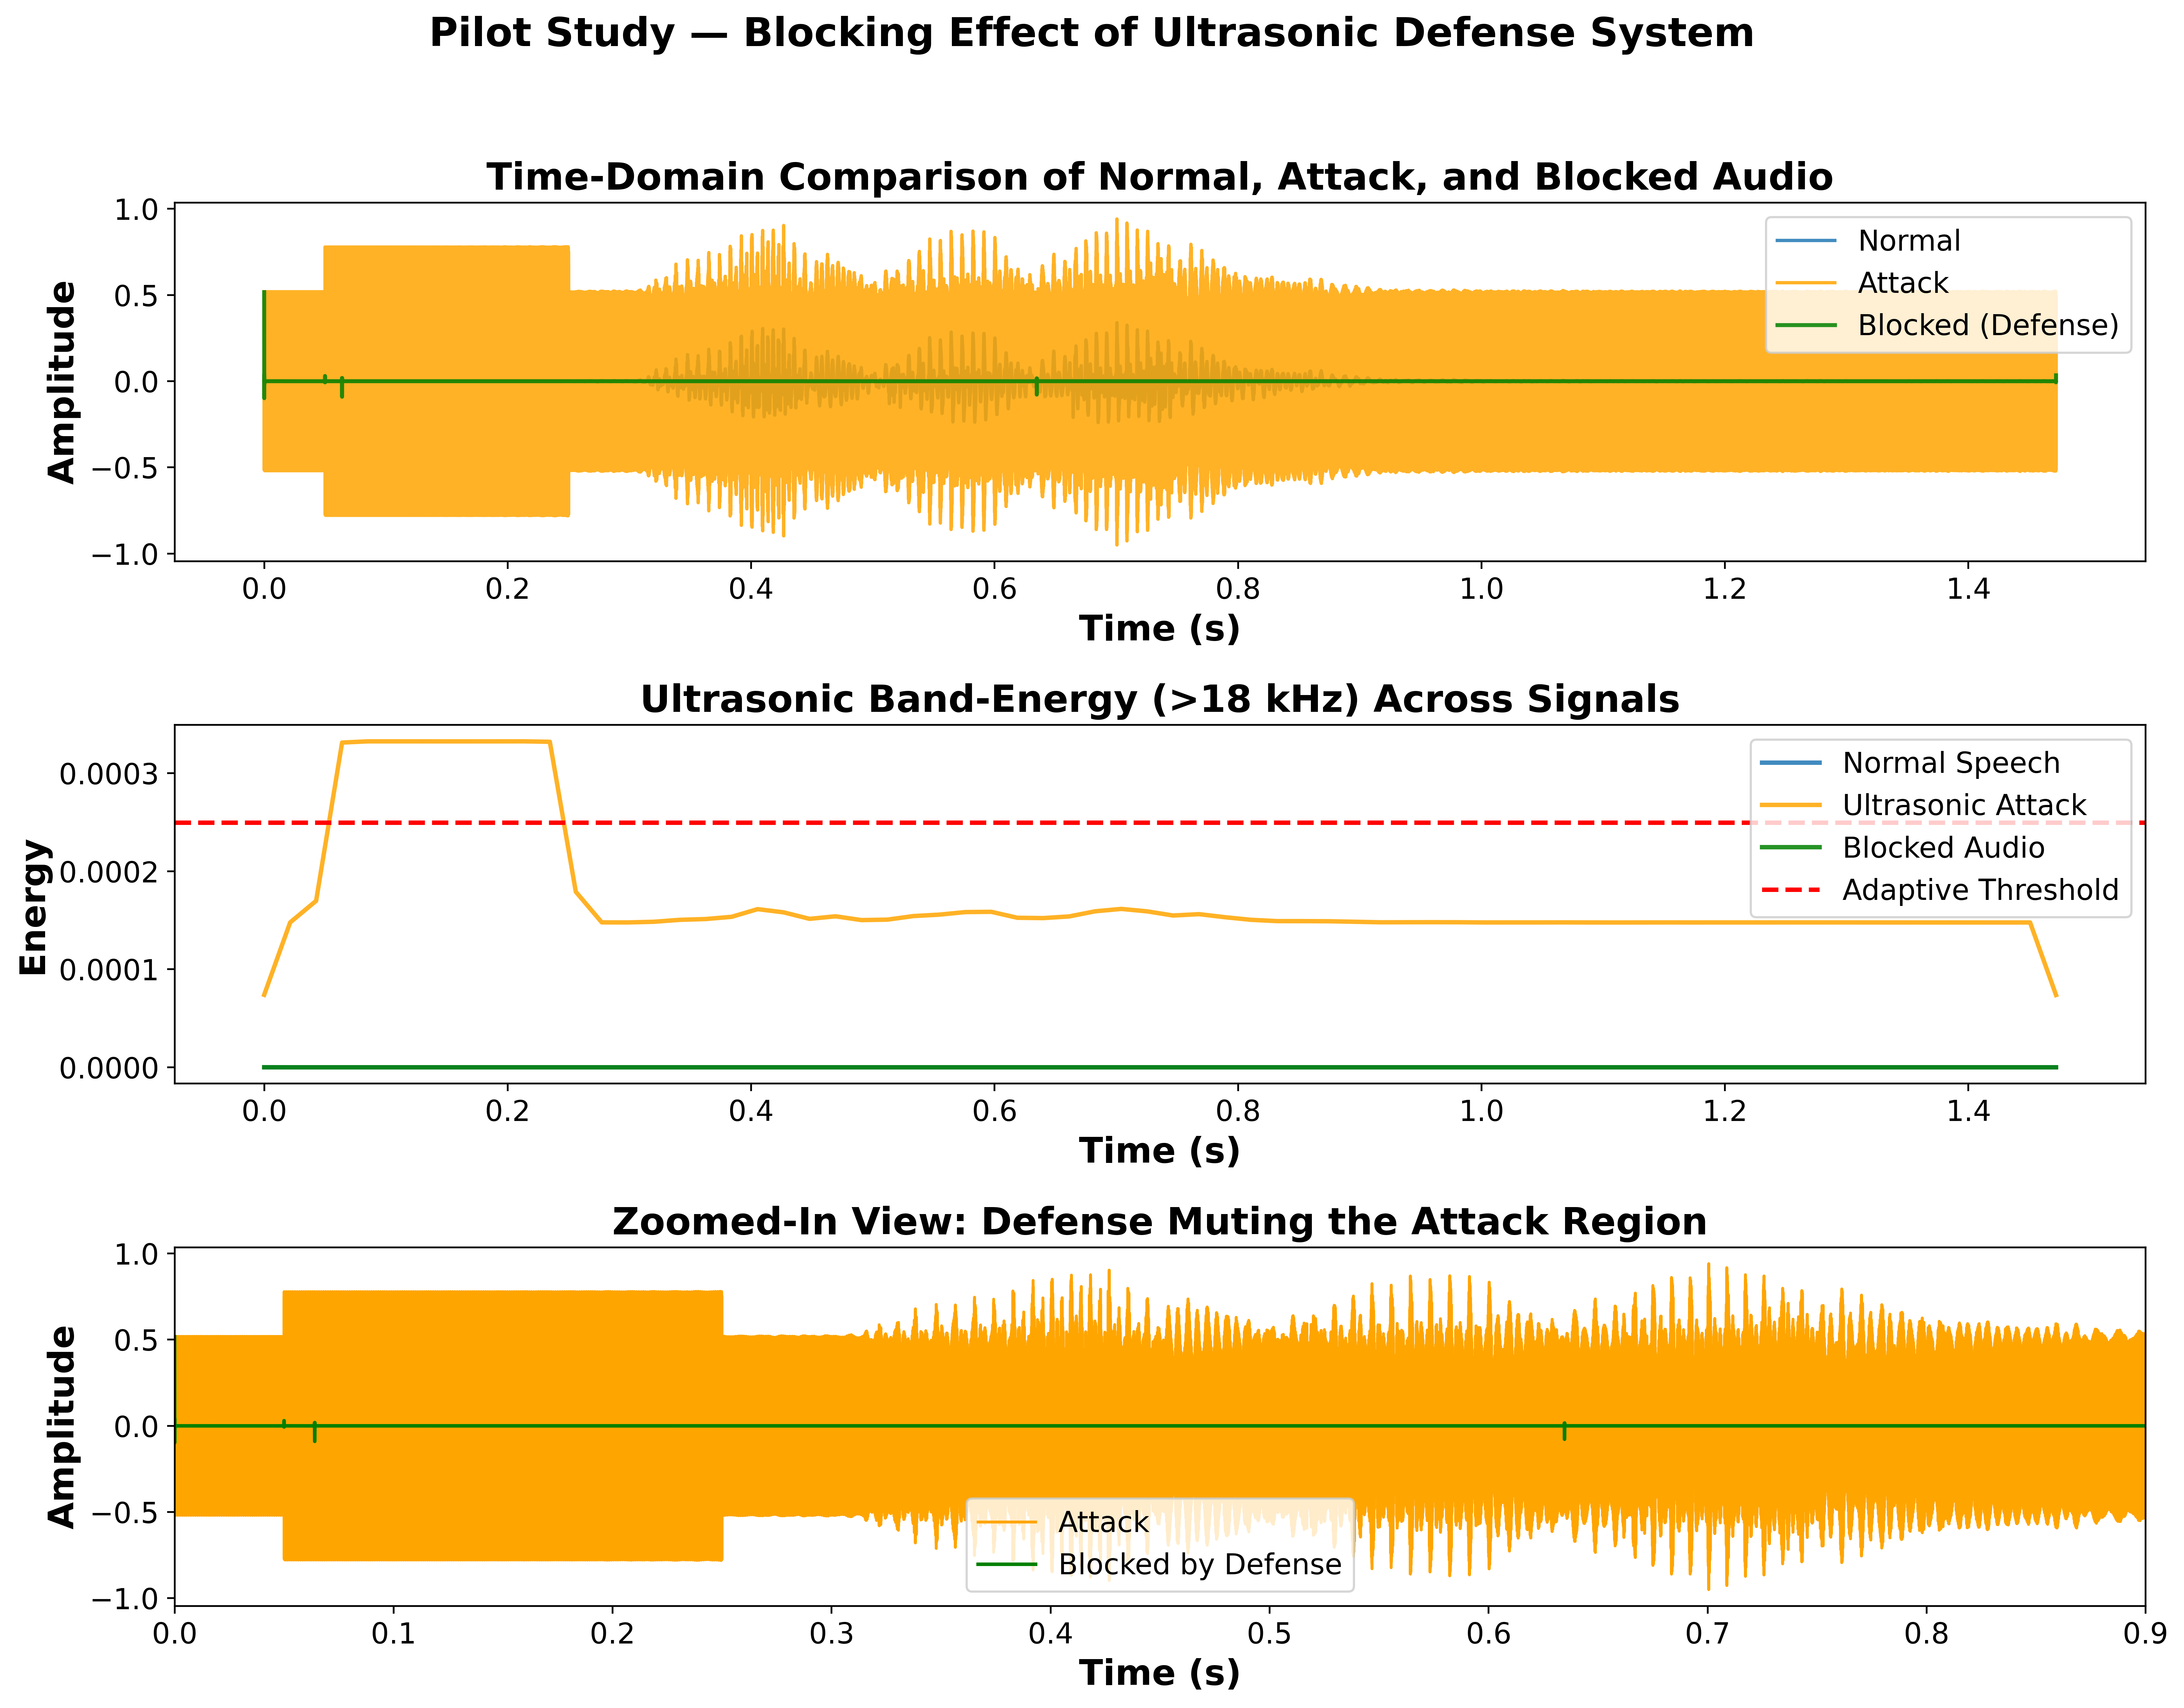

📌 Saved as: blocking_figure_print_ready.png


In [ ]:
import numpy as np
import librosa
import soundfile as sf
import matplotlib.pyplot as plt
from scipy.signal import stft

# Load all 3 audio signals
normal_file  = "hey_google_96k.wav"
attack_file  = "attack_am_strong_23k.wav"
blocked_file = "blocked.wav"

x_norm, sr = librosa.load(normal_file, sr=96000)
x_att , _  = librosa.load(attack_file, sr=96000)
x_blk , _  = librosa.load(blocked_file, sr=96000)

nfft = 4096
hop = 2048

def compute_band_energy(x):
    f, t, Z = stft(x, fs=sr, nperseg=nfft, noverlap=hop)
    Zmag = np.abs(Z)
    band_mask = (f >= 18000) & (f <= 34000)
    E = np.mean(Zmag[band_mask,:]**2, axis=0)
    thr = np.percentile(E, 95) * 0.75
    return t, E, thr

tn, En, thr_n = compute_band_energy(x_norm)
ta, Ea, thr_a = compute_band_energy(x_att)
tb, Eb, thr_b = compute_band_energy(x_blk)

# ---------- PLOT STYLING FOR PUBLICATIONS ----------
plt.rcParams["font.size"] = 15
plt.rcParams["axes.titlesize"] = 17
plt.rcParams["axes.titleweight"] = "bold"
plt.rcParams["axes.labelsize"] = 16
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["figure.dpi"] = 500

fig, axes = plt.subplots(3, 1, figsize=(14, 11))
plt.subplots_adjust(hspace=0.35)

# -------- 1) Waveforms --------
t_norm = np.arange(len(x_norm)) / sr
t_att  = np.arange(len(x_att)) / sr
t_blk  = np.arange(len(x_blk)) / sr

axes[0].plot(t_norm, x_norm, linewidth=1.5, label="Normal", alpha=0.85)
axes[0].plot(t_att,  x_att,  linewidth=1.5, label="Attack", alpha=0.85, color="orange")
axes[0].plot(t_blk,  x_blk,  linewidth=1.8, label="Blocked (Defense)", alpha=0.85, color="green")
axes[0].set_title("Time-Domain Comparison of Normal, Attack, and Blocked Audio")
axes[0].set_xlabel("Time (s)")
axes[0].set_ylabel("Amplitude")
axes[0].legend(fontsize=13, loc="upper right")

# -------- 2) Band-Energy Curves --------
axes[1].plot(tn, En, linewidth=2, label="Normal Speech", alpha=0.85)
axes[1].plot(ta, Ea, linewidth=2, label="Ultrasonic Attack", alpha=0.85, color="orange")
axes[1].plot(tb, Eb, linewidth=2, label="Blocked Audio", alpha=0.85, color="green")
axes[1].axhline(thr_a, color='r', linestyle='--', linewidth=2, label="Adaptive Threshold")
axes[1].set_title("Ultrasonic Band-Energy (>18 kHz) Across Signals")
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("Energy")
axes[1].legend(fontsize=13)

# -------- 3) Final Mute Region Visualization --------
axes[2].plot(t_att, x_att, linewidth=1.3, color="orange", label="Attack")
axes[2].plot(t_blk, x_blk, linewidth=1.6, color="green", label="Blocked by Defense")
axes[2].set_title("Zoomed-In View: Defense Muting the Attack Region")
axes[2].set_xlabel("Time (s)")
axes[2].set_ylabel("Amplitude")
axes[2].set_xlim(0, 0.9)  # adjust based on your attack location
axes[2].legend(fontsize=13)

plt.suptitle("Pilot Study — Blocking Effect of Ultrasonic Defense System", fontsize=18, fontweight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.96])

plt.savefig("blocking_figure_print_ready.png", dpi=500)
plt.show()

print("📌 Saved as: blocking_figure_print_ready.png")
